## Randomised benchmarking

Randomised benchmarking on multiple qubits consitsts of inserting a set of randomly chosen Clifford group gates into a circuit, and checking that the outcome is the expected outcome. Clifford group gates are chosen to be deterministic and classically simulable. We will restrict ourselves to CNOT and rotations about a major axis (Rx, Ry, Rz).

Here we will write some code to perform randomised benchmarking on the Rigetti Acorn chip.

For a paper on randomised benchmarking on superconducting qubits, see: https://arxiv.org/pdf/0707.0963.pdf

In [236]:
import numpy as np
import copy
from random import randint
import pyquil
from pyquil.quil import Program, Pragma
from pyquil.api import QVMConnection
from pyquil.api import QPUConnection
from pyquil.api import get_devices
from pyquil.gates import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
%matplotlib inline

In [247]:
no_of_gates = 5

#Function to decide upon randomised gates, up to a limit
def randomGates(qubit_a = 0, no_of_gates = 30):
    prog = Program()
    sequence_length = no_of_gates
    sequence = [0]*sequence_length
    inverse_sequence = [0]*sequence_length
    
    gate_set = {0:RX, 1:RZ}
    
    inverse_gate_set = {0:RX, 1:RZ}
    for i in range(sequence_length):
        a  = qubit_a
        
        random_choice = randint(0,1)
        gate = gate_set[random_choice]
        inverse_gate = inverse_gate_set[random_choice]

        gate = gate((np.pi/2),(a))
        inverse_gate = inverse_gate((-np.pi/2),(a))
        sequence[i] = gate
        inverse_sequence[i] = inverse_gate
    
    #prog.inst(("PRAGMA COMMUTING_BLOCKS"))  
    prog.inst(("PRAGMA PRESERVE_BLOCK"))
    for i in sequence:
        prog.inst(i)
    for i in reversed(inverse_sequence):
        prog.inst(i)
    prog.inst(("PRAGMA END PRESERVE_BLOCK"))
    #prog.inst(("PRAGMA END_COMMUTING_BLOCKS"))
    return prog
    
print(randomGates(no_of_gates = no_of_gates))

PRAGMA PRESERVE_BLOCK
RZ(pi/2) 0
RZ(pi/2) 0
RX(pi/2) 0
RZ(pi/2) 0
RX(pi/2) 0
RX(-pi/2) 0
RZ(-pi/2) 0
RX(-pi/2) 0
RZ(-pi/2) 0
RZ(-pi/2) 0
PRAGMA END PRESERVE_BLOCK



In [248]:
def fidelity_of_QPU(trials = 100, qubit_a = 0, no_of_gates = 30):
    devices = get_devices(as_dict = True)
    acorn = devices['19Q-Acorn']
    qvm = QVMConnection()
    noisy_qvm = QVMConnection(acorn)
    qpu = QPUConnection(acorn)
    
    randomisedProgram = randomGates(qubit_a, no_of_gates)
    classical_regs = [0]*(qubit_a+1)
    
    for i in range((qubit_a+1)):
        classical_regs[i] = i
    qpu_regs = copy.deepcopy(classical_regs)
    qvm_regs = copy.deepcopy(classical_regs)
    for i in classical_regs:
        randomisedProgram.measure(i,i)
    expected_state = qvm.run(randomisedProgram, qvm_regs, trials)
    #qpu_state = qpu.run(randomisedProgram, qpu_regs, trials)
    noisy_model = noisy_qvm.run(randomisedProgram, qvm_regs, trials)

    #fidelity = (1 - np.sum(qpu_state)/trials)
    noise_model_fidelity = (1 - np.sum(noisy_model)/trials)
    perfect_fidelity = (1 - np.sum(expected_state)/trials) #If this isn't == 1 you have a problem!
    #print("The QPU fidelity is: {} \n".format(fidelity))
    #print("The QVM noise model fidelity is: {} \n  The expected fidelity is: {} (check this is == 1)".format(noise_model_fidelity, perfect_fidelity))
    
    #return circuit_length, noise_model_fidelity, fidelity
    return noise_model_fidelity, 'Na'

In [249]:
def randomisedBenchmarking(no_of_gates = 30):
    results = collections.defaultdict(dict)
    dead_qubits = [2,3,15,18]
    for i in range(19):
        if i not in dead_qubits:
            for n in range(no_of_gates):
                model_fidelity, real_fidelity = fidelity_of_QPU(qubit_a = i, no_of_gates = n)
                results[i][n] = [model_fidelity, real_fidelity]

    #print("{:<8} {:<15} {:<10}".format('Qubit','Model Fidelity','Real Fidelity'))
    #for qubit, data in results.items():
        #no_of_gates, model, real = data
        #print("{:<8} {:<15} {:<10}".format(qubit, no_of_gates, model, real))
    return results

results = randomisedBenchmarking(no_of_gates)

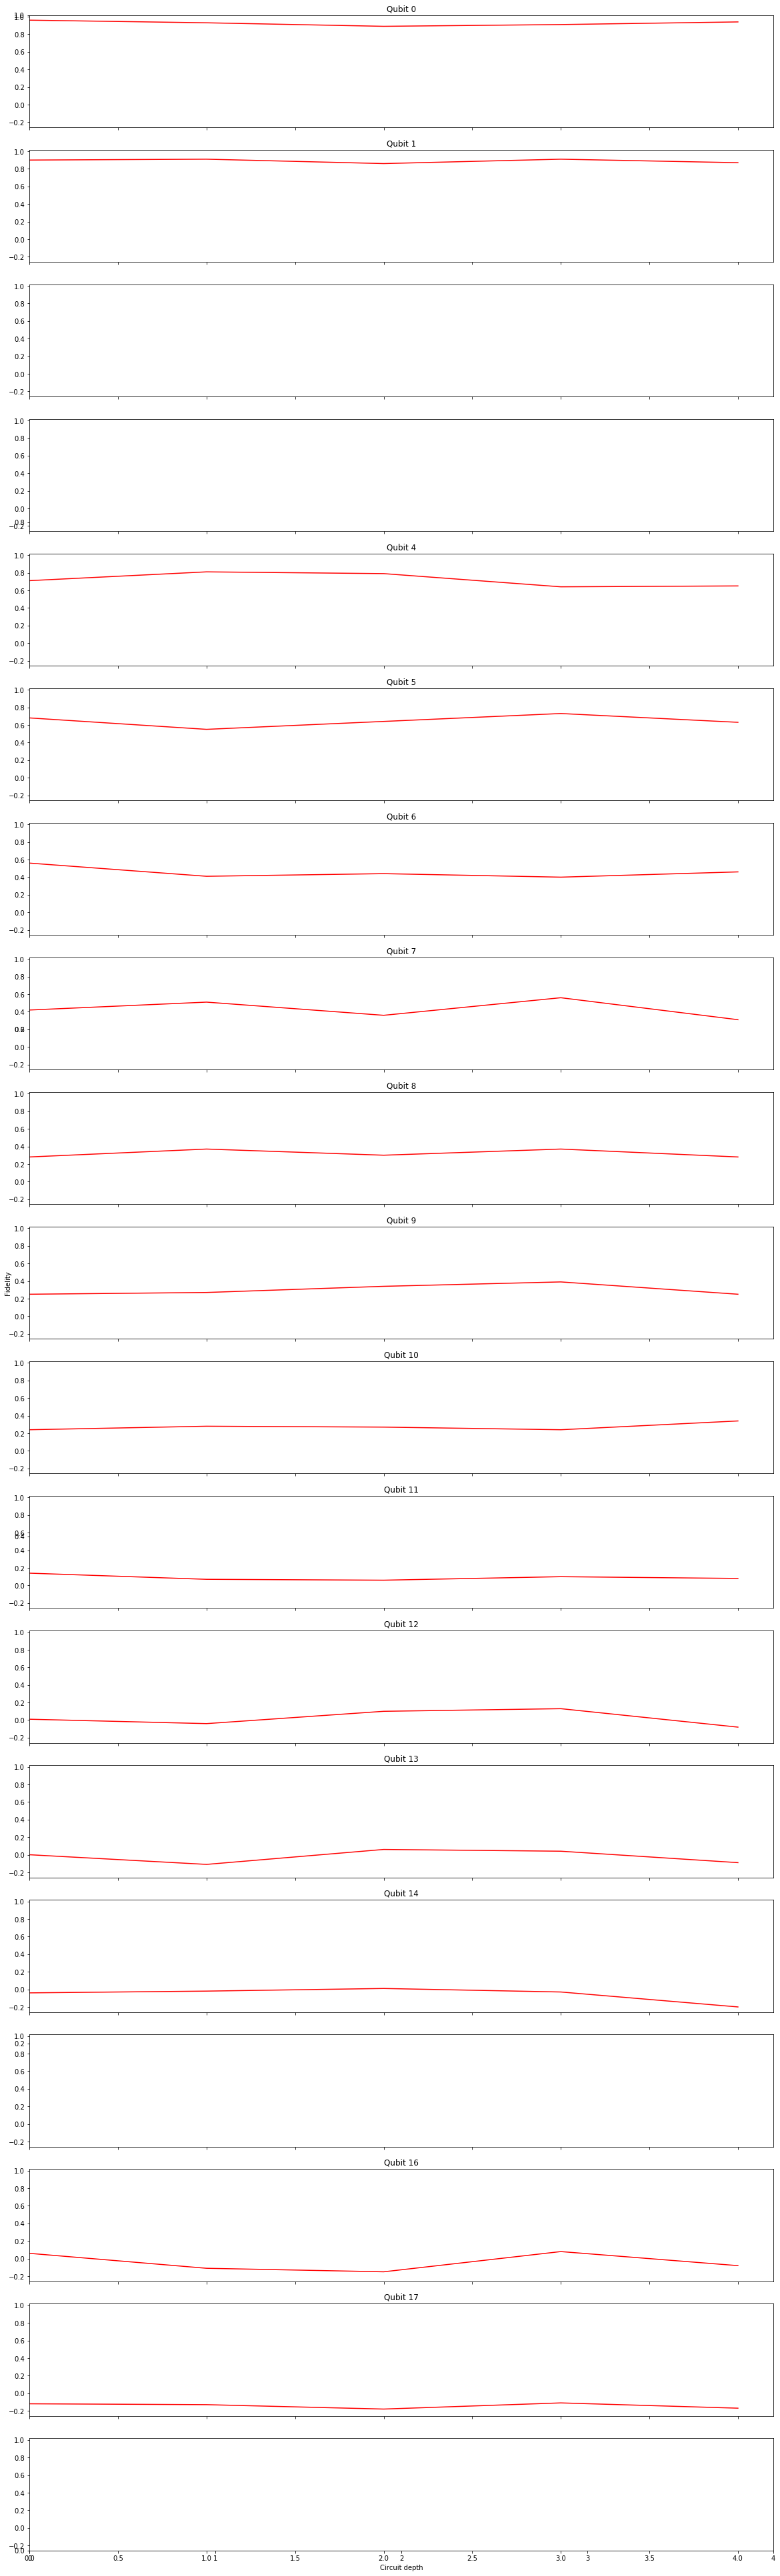

In [250]:
mpl.rcParams['figure.figsize'] = (20,70)
def plot_results(results, no_of_gates = 30):
    fig, axes =  plt.subplots(nrows = 19, ncols = 1, sharex = True, sharey =True)
    for qubit, data in results.items():
        plot_list = np.empty([no_of_gates,2])
        for circuit_length, fidelities in data.items():
            model, real = fidelities[0], fidelities[1]
            plot_list[circuit_length][0] = circuit_length
            plot_list[circuit_length][1] = model
        axes[qubit].plot([x[:][0] for x in plot_list], [y[:][1] for y in plot_list], 'r')
        axes[qubit].set_xlim(xmin = 0)
        axes[qubit].set_title('Qubit {}'.format(qubit))
    fig.add_subplot(111, frameon = False)
    plt.ylabel('Fidelity')
    plt.xlabel('Circuit depth')
    plt.xticks(range(0,no_of_gates))
    plt.show
    
plot_results(results,no_of_gates)